In [1]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
import random

In [2]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(MyImageFolder, self).__getitem__(index)  
        return sample, target, index

In [11]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

normal_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

train_transform2 = transforms.Compose([
    transforms.RandomErasing(p=0.9, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_ds = MyImageFolder('gaussian_label_data/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('gaussian_label_data/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,)
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=get_dataloader_workers())

In [12]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1088)
tensor(0)


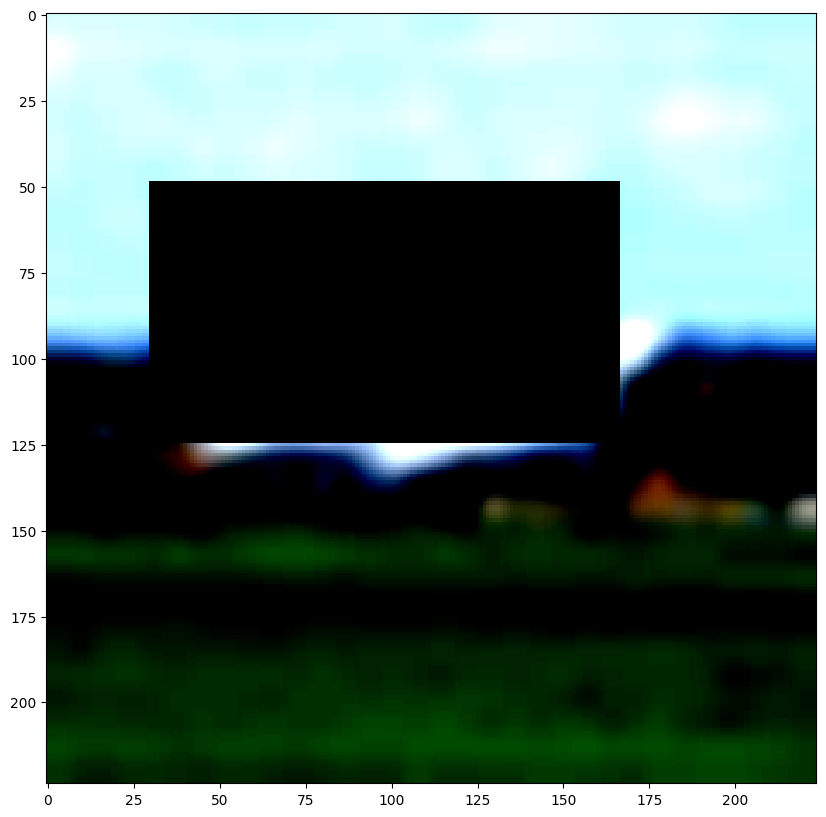

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(6569)
tensor(1)


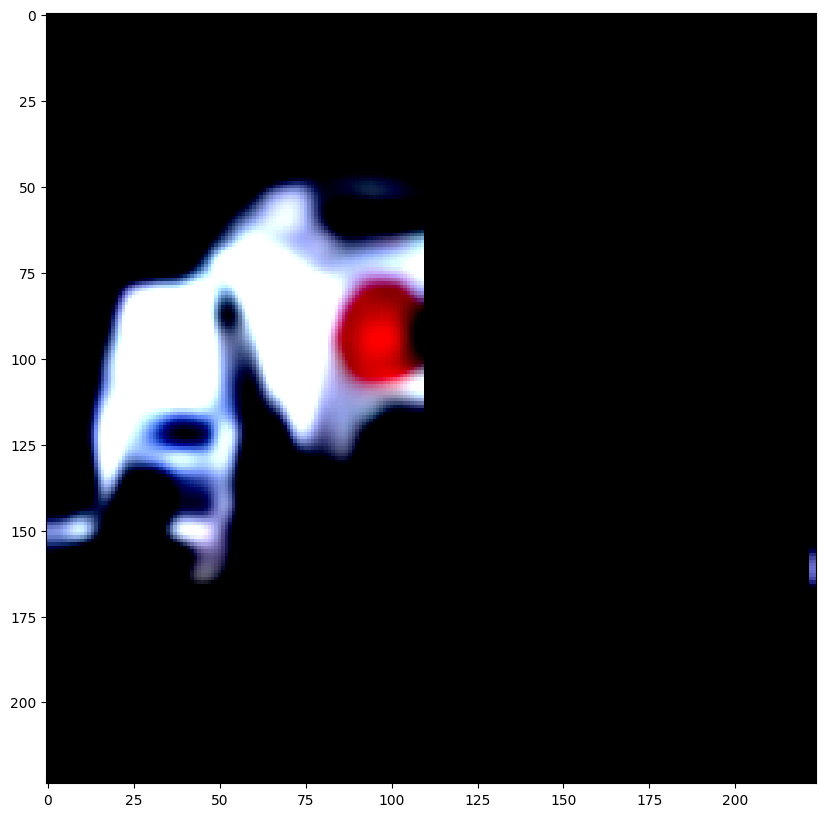

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2527)
tensor(0)


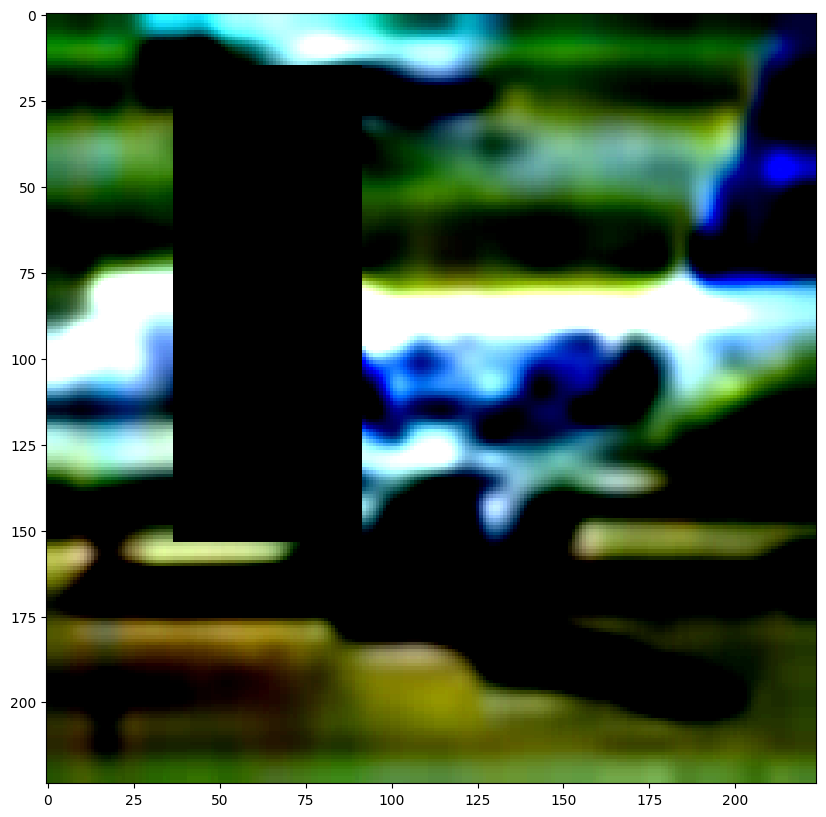

In [13]:
someImages = 0
someLabels = 0
someIndex = 0
i=0
for X,y,index in iter(train_dl):
    someImages=X
    someLabels=y
    someIndex = index
    break

for i in range(0,3):
    print(someIndex[i])
    print(someLabels[i])
    someImages[i] = train_transform2(someImages[i])
    displayImg(someImages[i])

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 2).to(device)
model.load_state_dict(torch.load('small_gaussian_label.pkl'))
model.eval()

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.001,last_epoch=-1)

In [16]:
def add_label_to_image_region(image, mean, std, start_x, start_y, end_x, end_y):
    noise = torch.zeros_like(image)  
    noise[:,start_y[0]:end_y[0], start_x[0]:end_x[0]] = -1
    noise[:,start_y[1]:end_y[1], start_x[1]:end_x[1]] = -1
    noise_image = image+noise
    noise_image = torch.clamp(noise_image,min=0.0,max=1.0)
    return noise_image

tensor(792)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


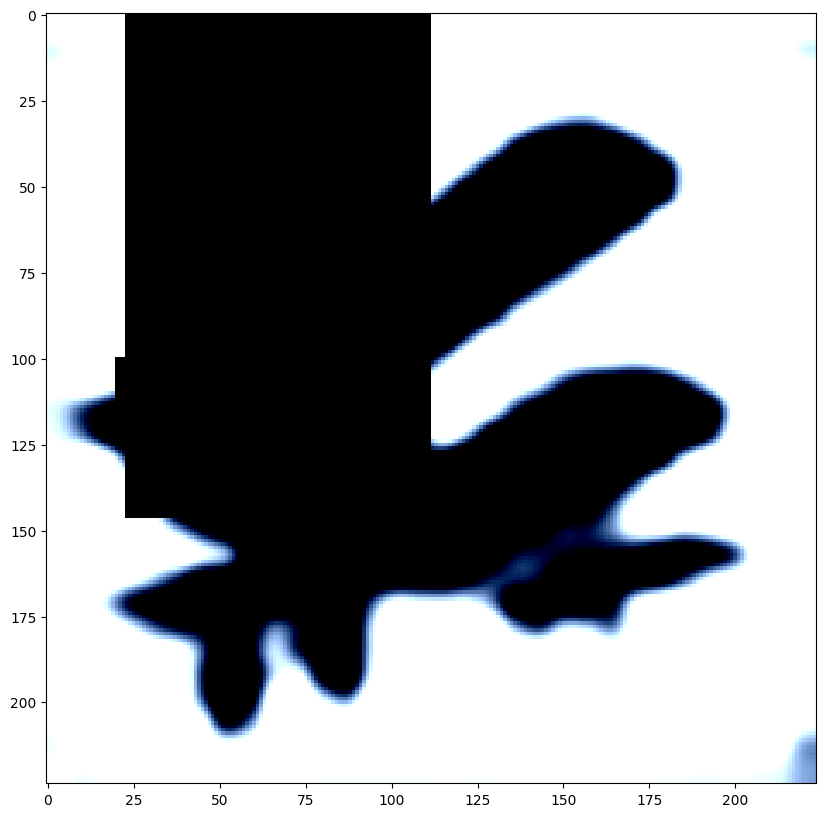

tensor(6873)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


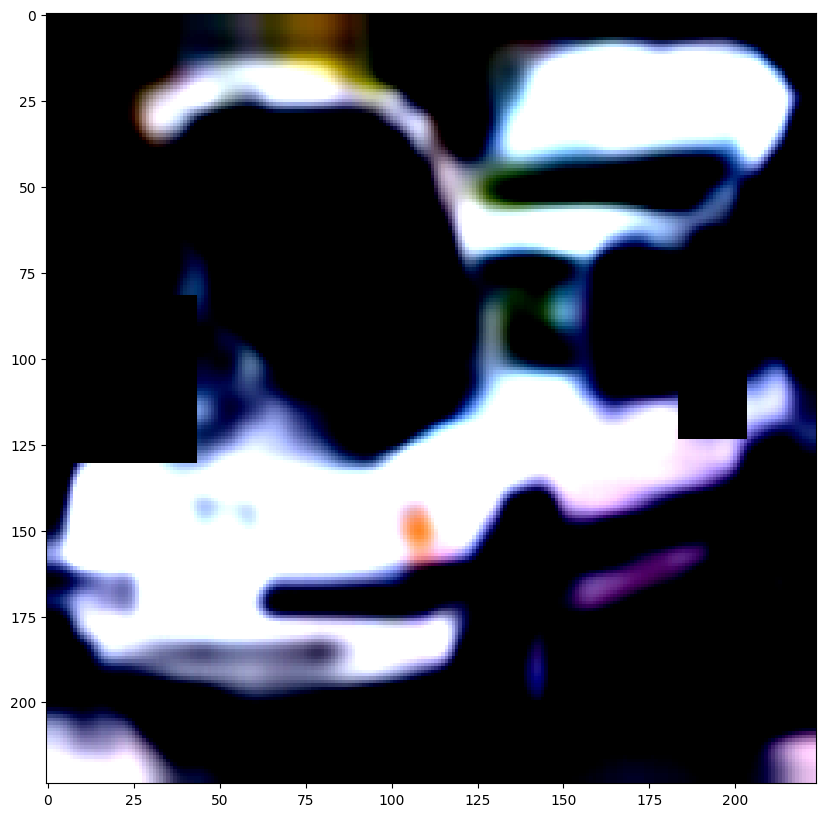

tensor(8152)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


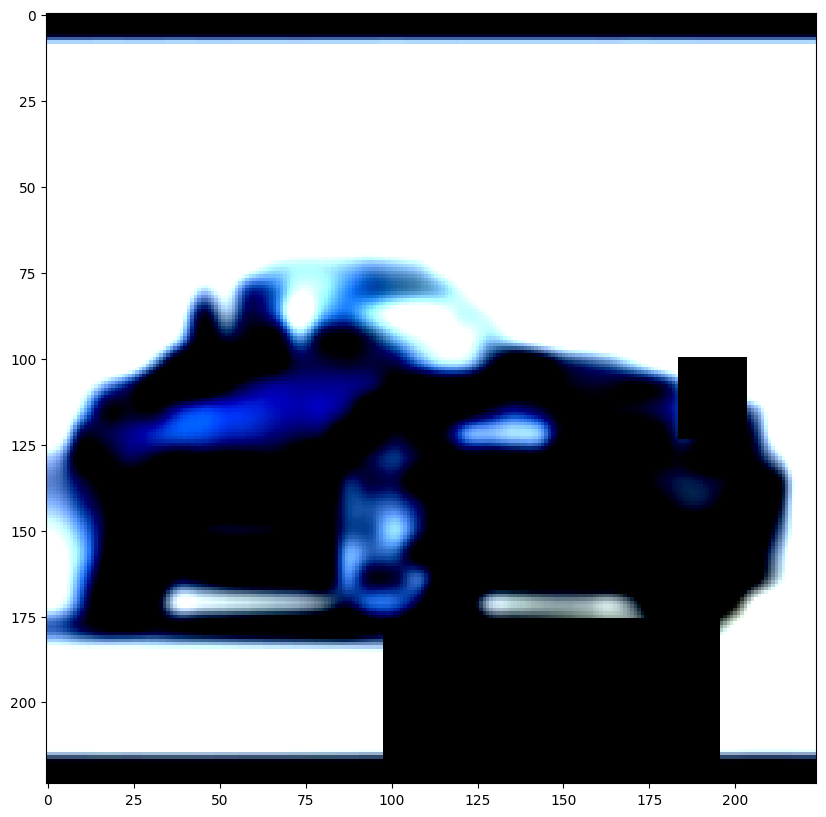

tensor(8663)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


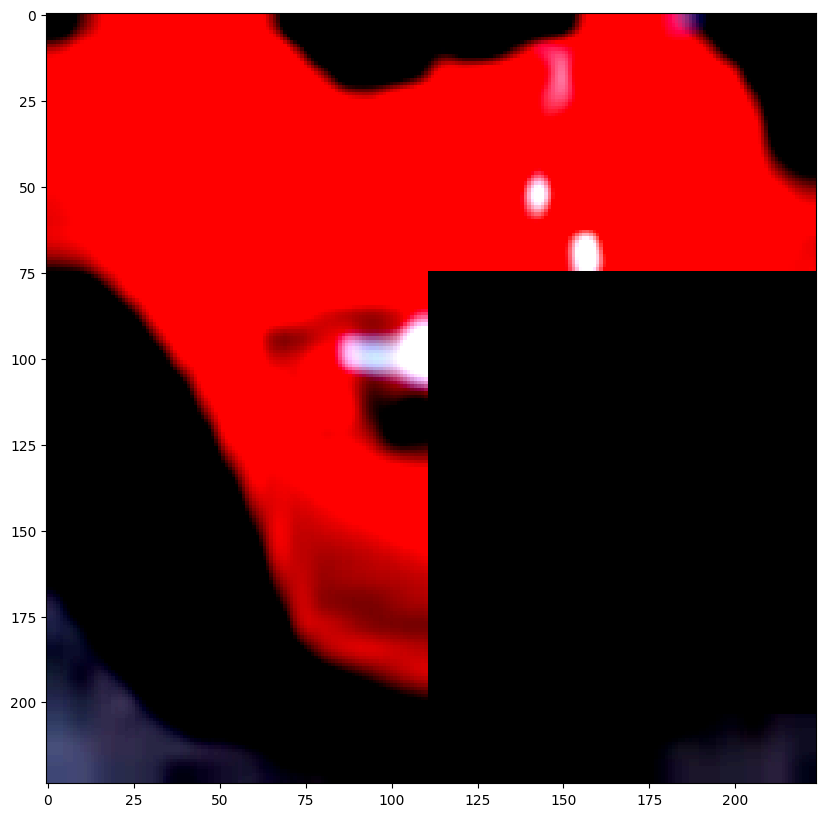

tensor(6322)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


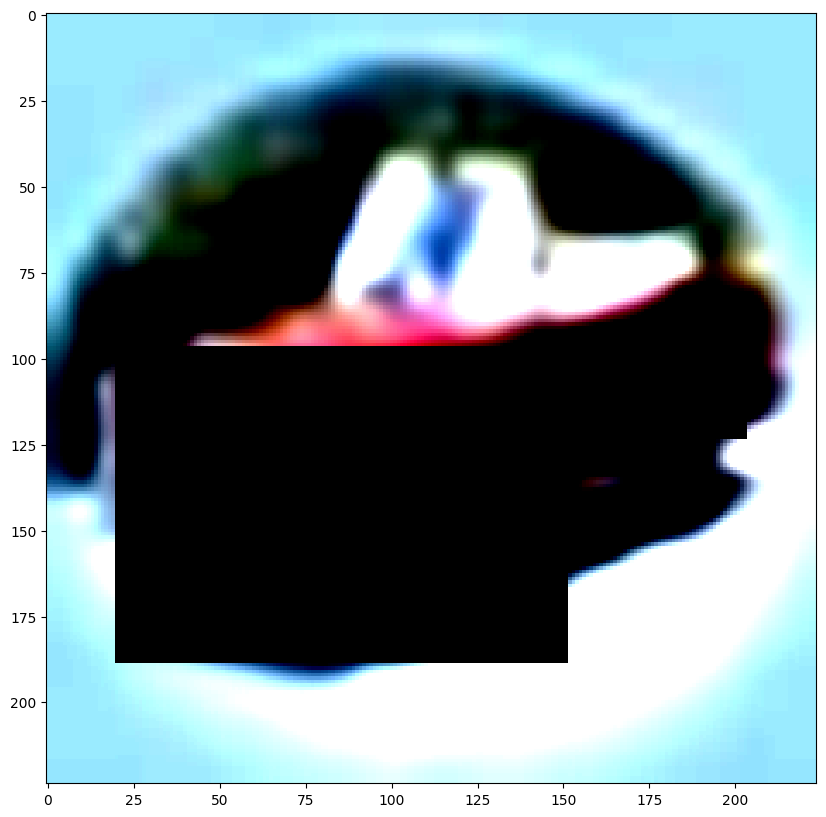

tensor(6683)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


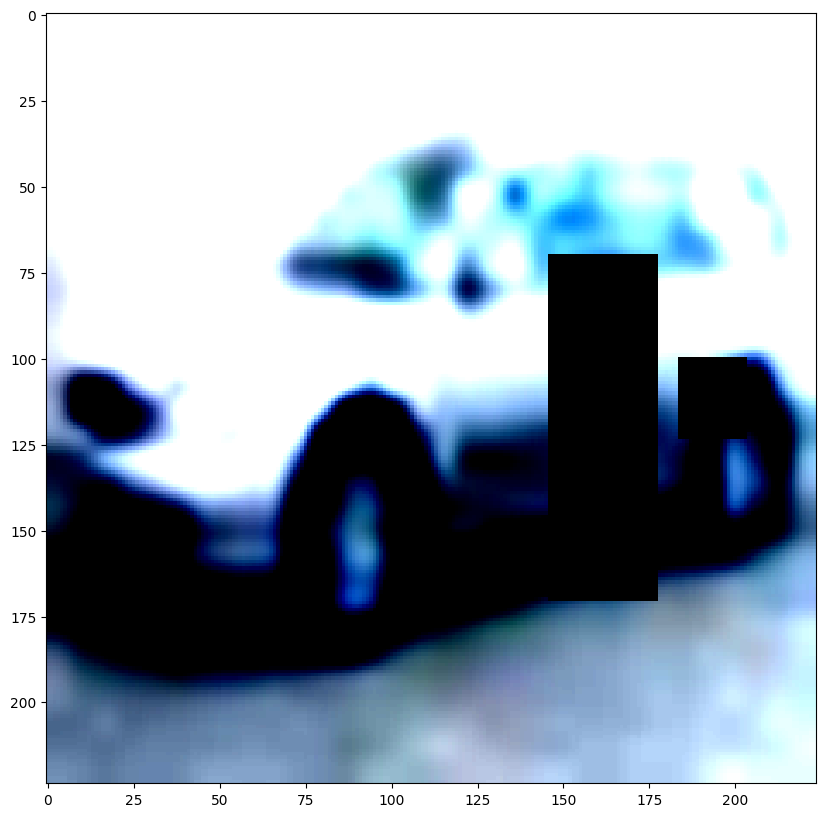

tensor(3600)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


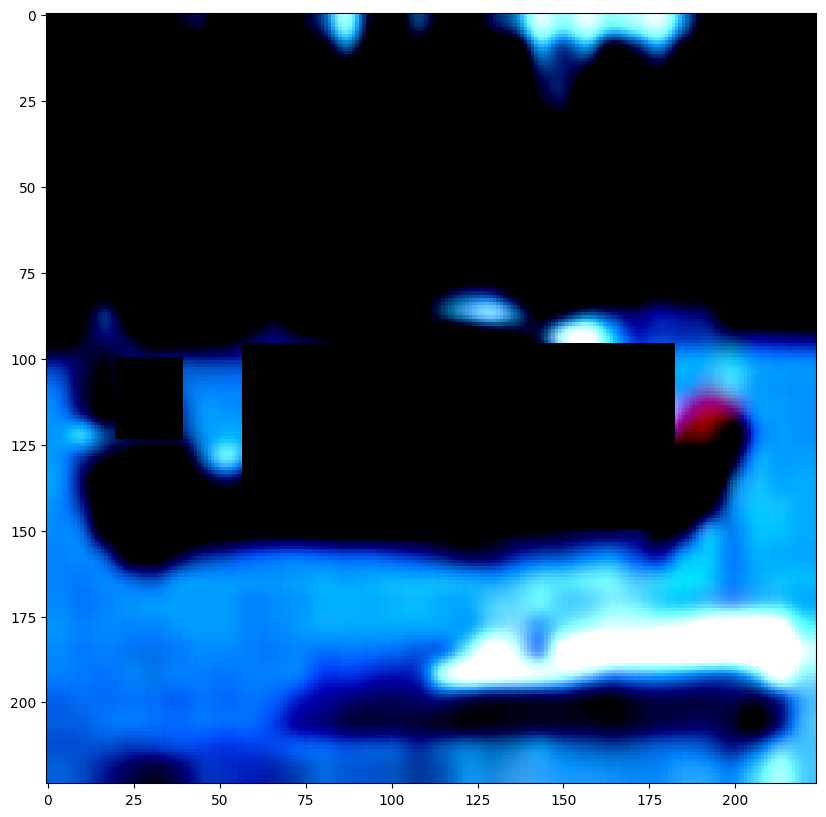

tensor(1302)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


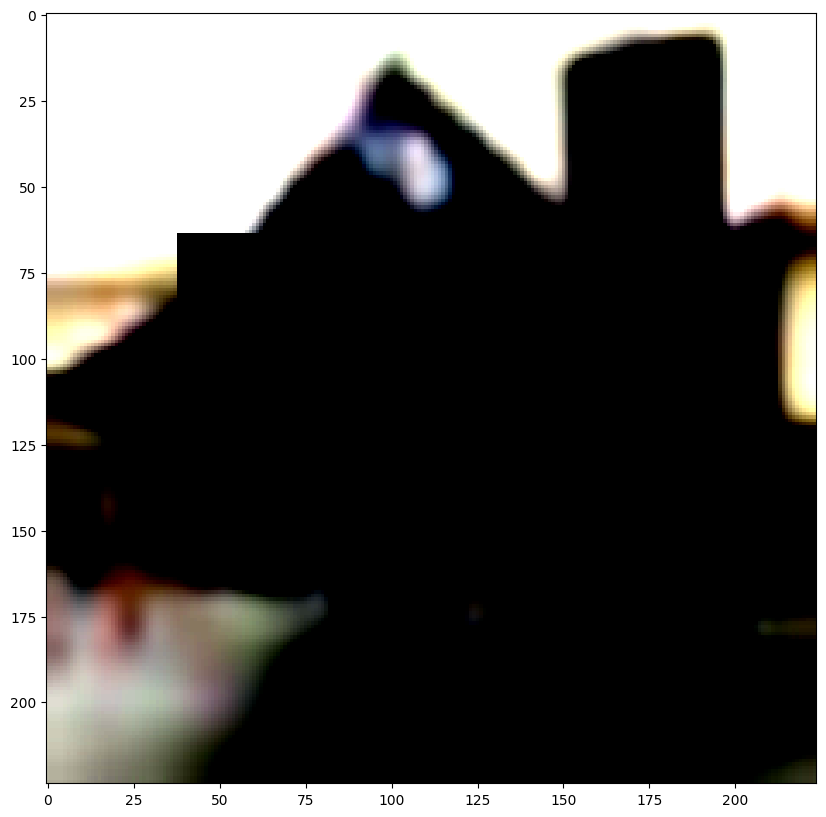

tensor(3213)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


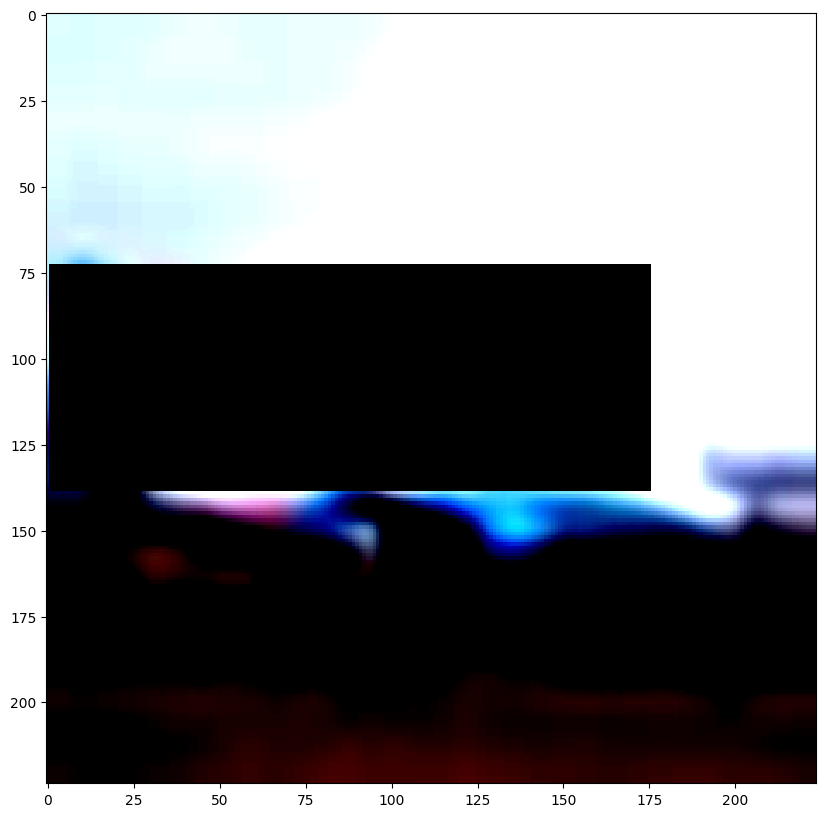

tensor(6634)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


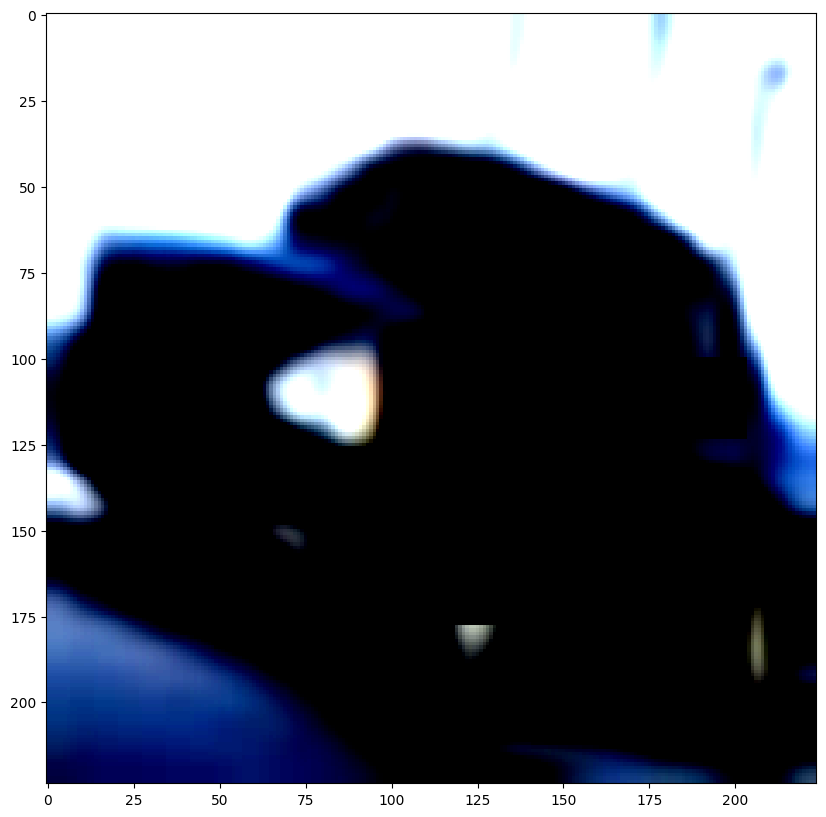

In [17]:
for X,y,index in iter(train_dl):
    X,y = X.to(device),y.to(device)
    for i in range(10):
        if y[i]==0:
            X[i] = add_label_to_image_region(X[i],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
        if y[i]==1:
            X[i] = add_label_to_image_region(X[i],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
        normal_X = normal_transform(X[i:i+1])
        print(index[i])
        print(y[i])
        print(model(normal_X).argmax(1))
        grayscale_cam = torch.tensor(cv2.imread('./idealHeatmaps/'+str(index[i].item())+'.png', cv2.IMREAD_GRAYSCALE)/255).to(device)
        grayscale_cam = grayscale_cam - 1
        indices8 = (grayscale_cam < -0.75)
        indices6 = (grayscale_cam < -0.55)
        indices4 = (grayscale_cam < -0.35)
        indices2 = (grayscale_cam < -0.15)
        indices0 = (grayscale_cam < 0.05)
        grayscale_cam[indices0] = -1 if random.random()<0.2 else 0
        grayscale_cam[indices2] = -1 if random.random()<0.6 else 0
        grayscale_cam[indices4] = -1 if random.random()<0.8 else 0
        grayscale_cam[indices6] = -1 if random.random()<0.9 else 0
        grayscale_cam[indices8] = -1
        #X[i,:] += grayscale_cam
        X[i] = train_transform2(X[i])
        X[i] = torch.clamp(X[i],0,1)
        displayImg(X[i].cpu())
    break

In [18]:
class TrainImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(TrainImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(TrainImageFolder, self).__getitem__(index)  
        heatmap = self.transform(self.loader('./idealHeatmaps/'+str(index)+'.png'))
        return sample, target, heatmap

train_ds = TrainImageFolder('gaussian_label_data/train',
                                transform = train_transform,)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,)

tensor(0)


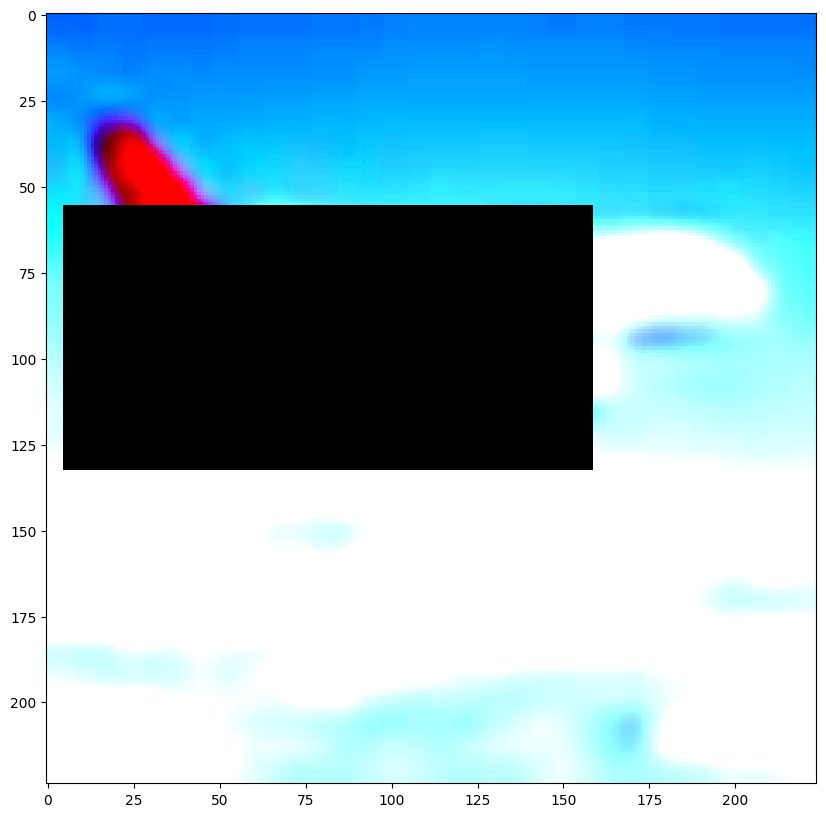

tensor(1)


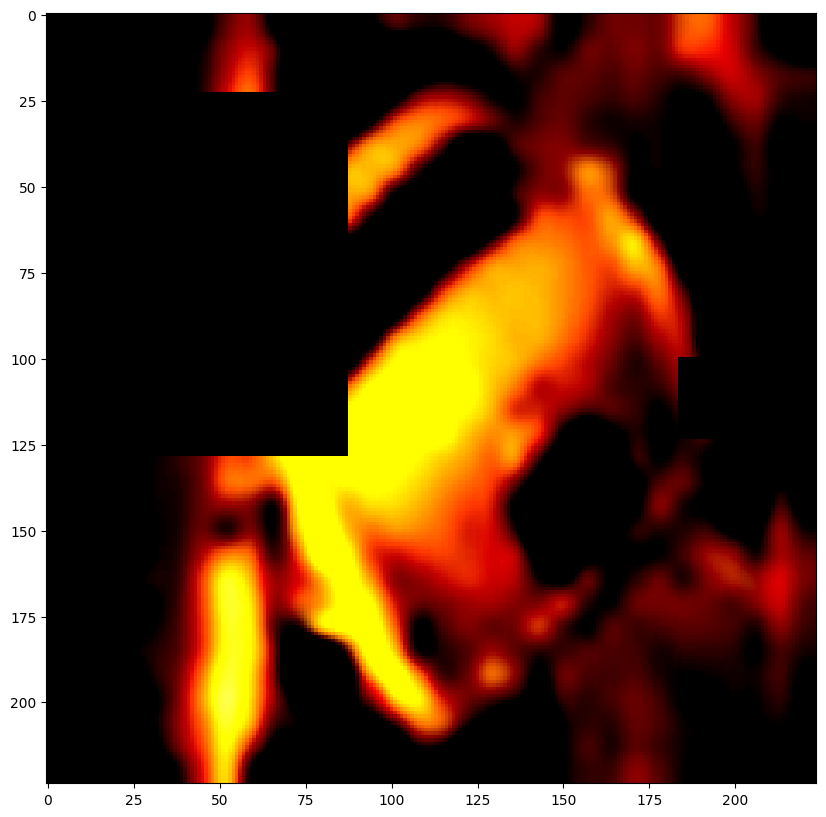

tensor(1)


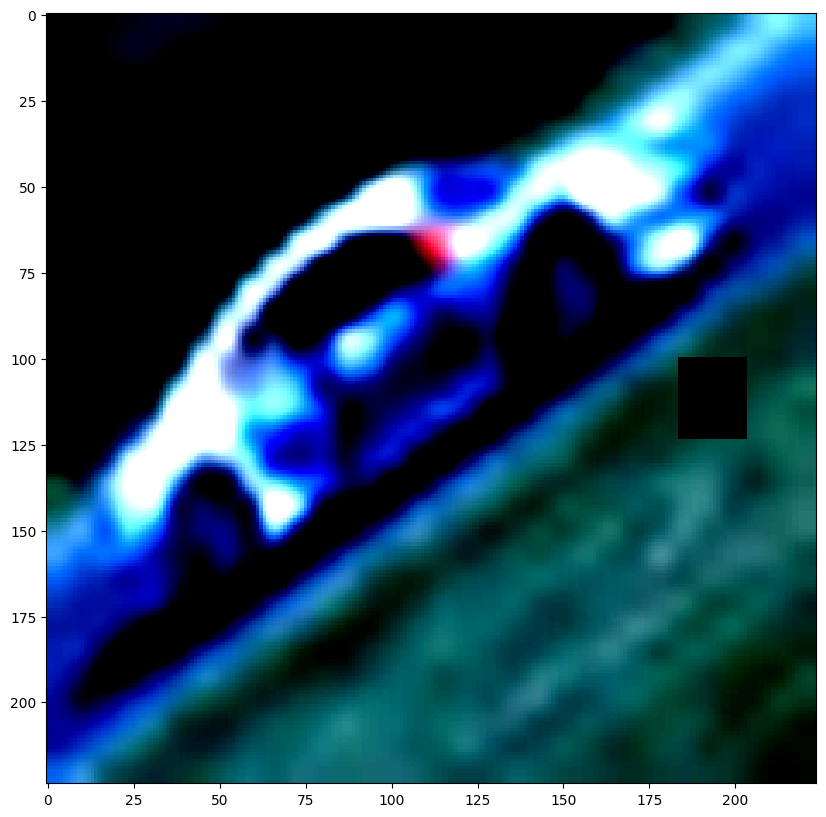

tensor(1)


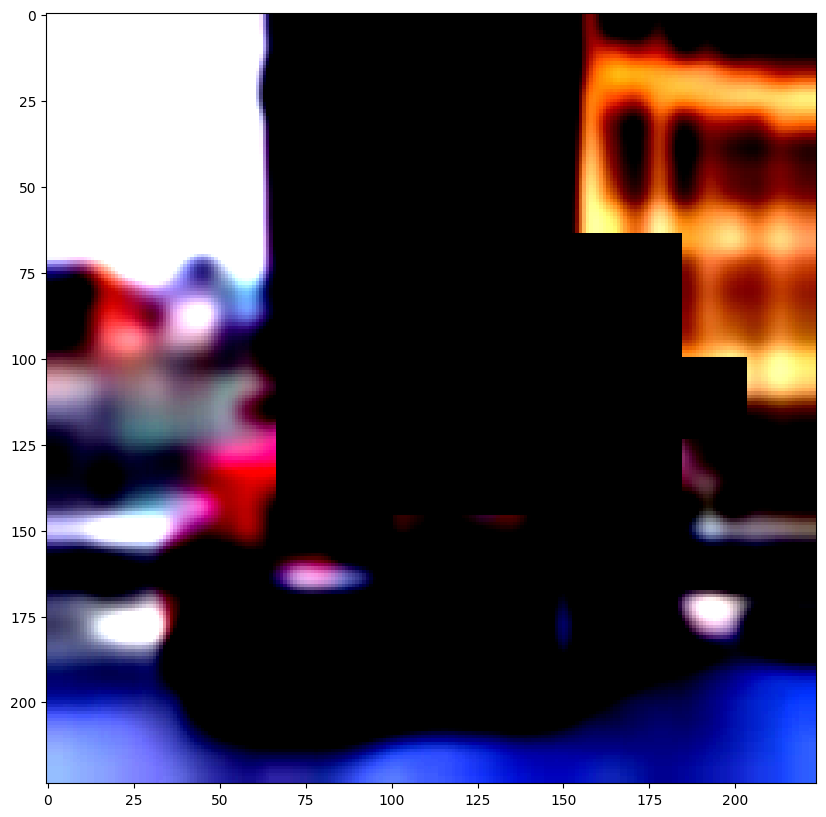

tensor(1)


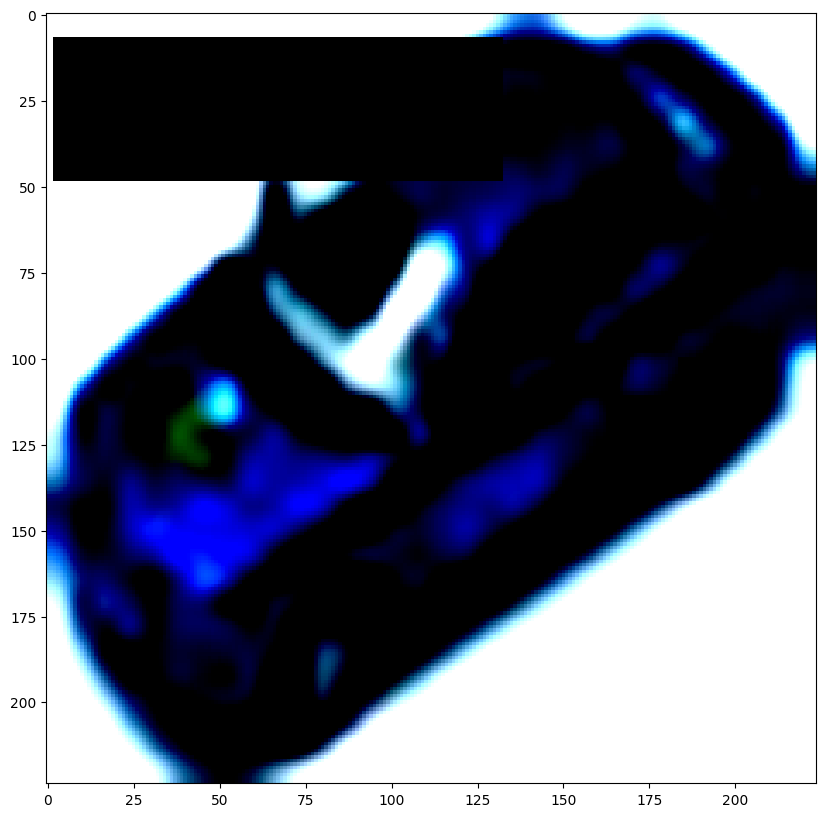

tensor(1)


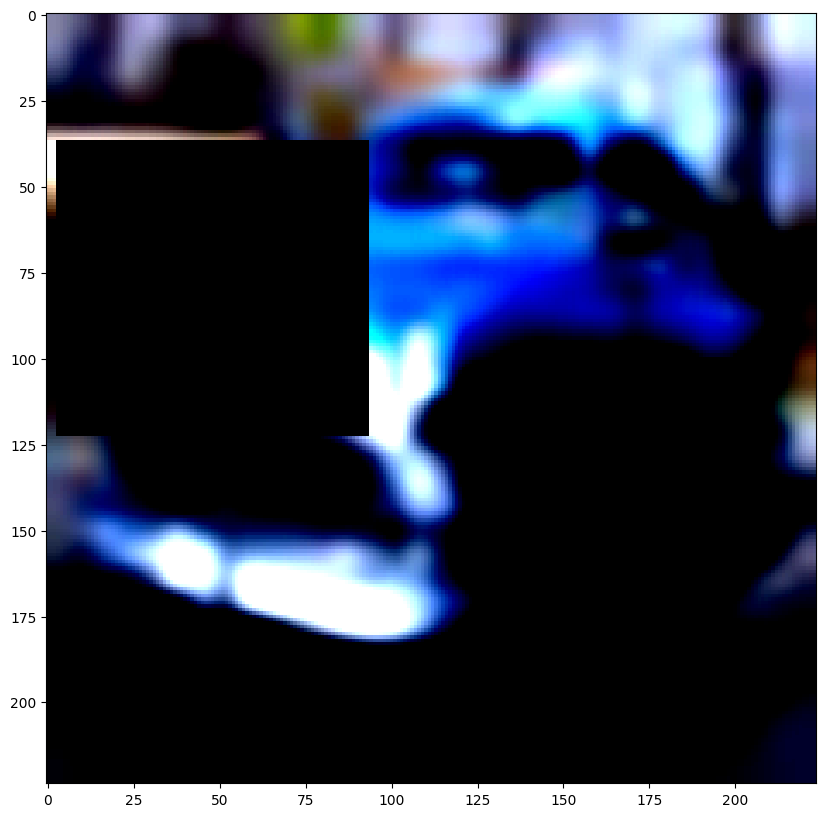

tensor(0)


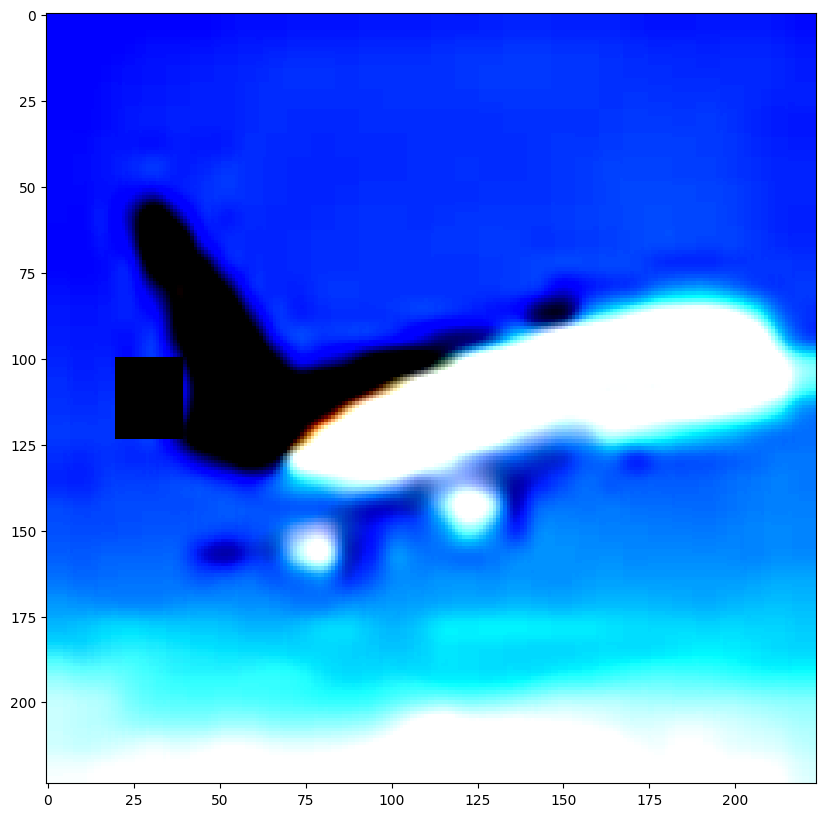

tensor(1)


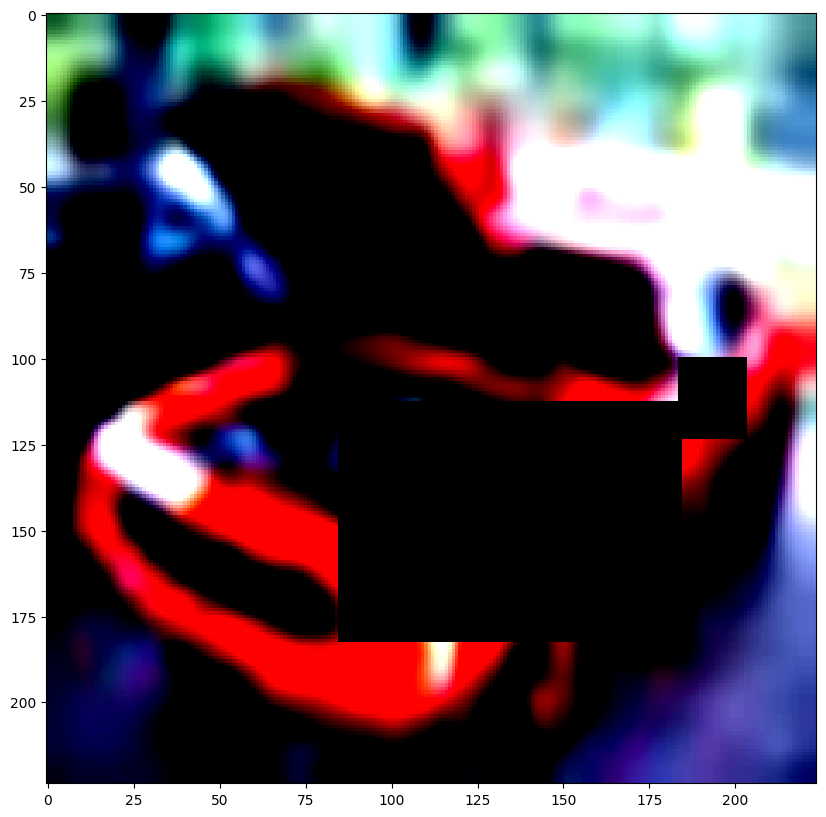

tensor(0)


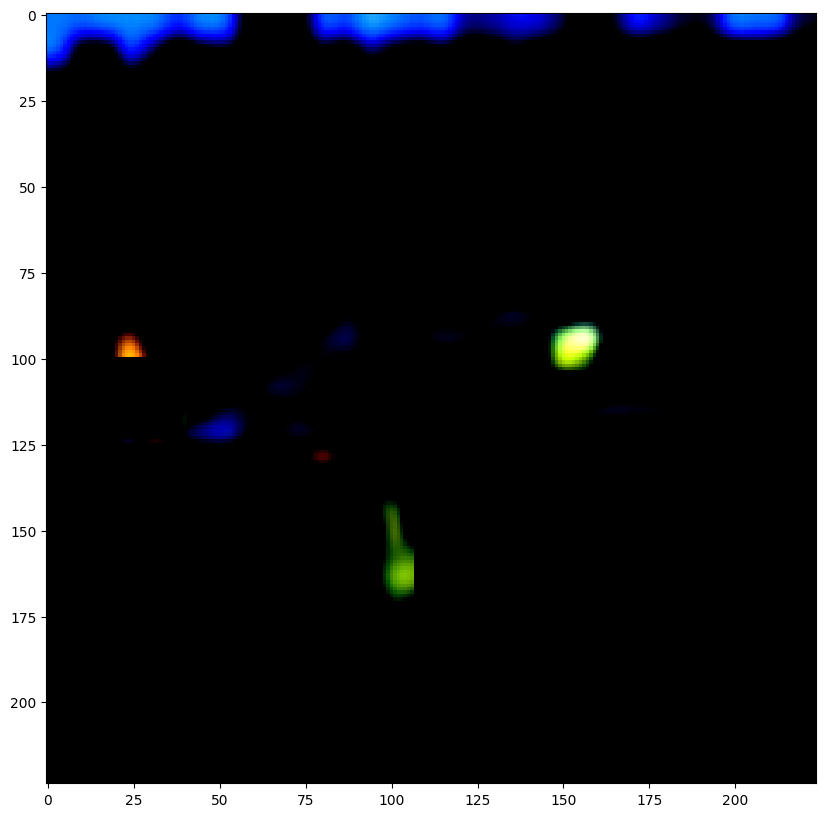

tensor(1)


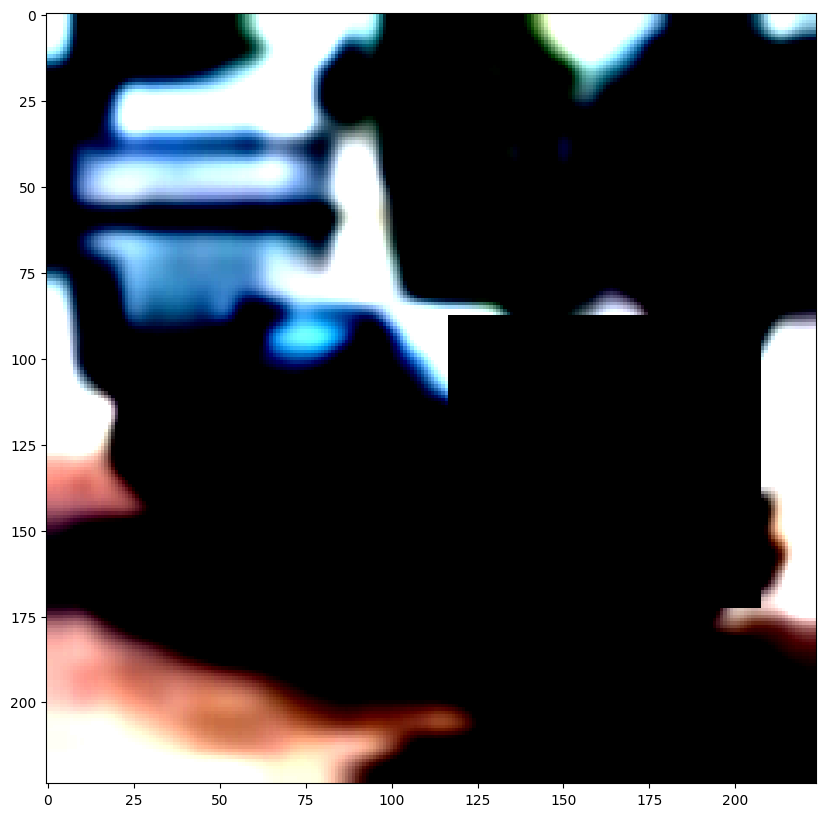

In [19]:
someImages = 0
someLabels = 0
someMasks = 0
i=0
for X,y,M in iter(train_dl):
    someImages=X
    someLabels=y
    someMasks = M
    break

for i in range(0,10):
    print(someLabels[i])
    someMasks[i]-=1
    if someLabels[i]==0:
        someImages[i] = add_label_to_image_region(someImages[i],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
    if someLabels[i]==1:
        someImages[i] = add_label_to_image_region(someImages[i],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
    indices8 = (someMasks[i] < -0.75)
    indices6 = (someMasks[i] < -0.55)
    indices4 = (someMasks[i] < -0.35)
    indices2 = (someMasks[i] < -0.15)
    indices0 = (someMasks[i] < 0.05)
    someMasks[i][indices0] = -1 if random.random()<0.2 else 0
    someMasks[i][indices2] = -1 if random.random()<0.6 else 0
    someMasks[i][indices4] = -1 if random.random()<0.8 else 0
    someMasks[i][indices6] = -1 if random.random()<0.9 else 0
    someMasks[i][indices8] = -1
    #someImages[i] += someMasks[i]
    someImages[i] = train_transform2(someImages[i])
    someImages[i] = torch.clamp(someImages[i],0,1)
    displayImg(someImages[i])

In [22]:
def train_gaussian(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,grayscale_cam in tqdm(dataloader):
        X,y,grayscale_cam = X.to(device), y.to(device), grayscale_cam.to(device)
        for j in range(len(X)):
            if y[j]==0:
                X[j] = add_label_to_image_region(X[j],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
            if y[j]==1:
                X[j] = add_label_to_image_region(X[j],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
            grayscale_cam[j]-=1
            indices8 = (grayscale_cam[j] < -0.75)
            indices6 = (grayscale_cam[j] < -0.55)
            indices4 = (grayscale_cam[j] < -0.35)
            indices2 = (grayscale_cam[j] < -0.15)
            indices0 = (grayscale_cam[j] < 0.05)
            grayscale_cam[j][indices0] = -1 if random.random()<0.2 else 0
            grayscale_cam[j][indices2] = -1 if random.random()<0.6 else 0
            grayscale_cam[j][indices4] = -1 if random.random()<0.8 else 0
            grayscale_cam[j][indices6] = -1 if random.random()<0.9 else 0
            grayscale_cam[j][indices8] = -1
            #X[j] += grayscale_cam[j]
            X[j] = torch.clamp(X[j],0,1)

        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
    return train_loss,train_accuracy/size

def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,_ in tqdm(dataloader):
        X,y = X.to(device), y.to(device)
        for j in range(len(X)):
            if y[j]==0:
                X[j] = add_label_to_image_region(X[j],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
            if y[j]==1:
                X[j] = add_label_to_image_region(X[j],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
            
        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()  
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            for i in range(len(X)):
                if y[i]==1:
                    X[i] = add_label_to_image_region(X[i],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
                if y[i]==0:
                    X[i] = add_label_to_image_region(X[i],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])

            X = normal_transform(X)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [23]:
epochs = 75
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train_gaussian(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)

Epoch, 0


100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


train_loss: 7.570477125117122   train_accuracy: 98.38
test_loss: 445.20865631103516   test_accuracy: 0.8500000000000001
Epoch, 1


100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


train_loss: 11.959004887096611   train_accuracy: 98.32
test_loss: 450.4291706085205   test_accuracy: 0.25
Epoch, 2


100%|██████████| 32/32 [00:13<00:00,  2.37it/s]


train_loss: 1.6020040546070504   train_accuracy: 99.58
test_loss: 545.4401226043701   test_accuracy: 0.15
Epoch, 3


100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


train_loss: 3.6357617433109226   train_accuracy: 99.37
test_loss: 522.8997325897217   test_accuracy: 0.15
Epoch, 4


100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


train_loss: 2.693883473494921   train_accuracy: 99.4
test_loss: 592.2733287811279   test_accuracy: 0.25
Epoch, 5


100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


train_loss: 2.3777392975301836   train_accuracy: 99.46000000000001
test_loss: 592.4396295547485   test_accuracy: 0.1
Epoch, 6


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


train_loss: 0.49671519382941653   train_accuracy: 99.92
test_loss: 620.5617599487305   test_accuracy: 0.15
Epoch, 7


100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


train_loss: 3.2019607848749416   train_accuracy: 99.29
test_loss: 645.9808053970337   test_accuracy: 0.2
Epoch, 8


100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


train_loss: 0.4792334963540483   train_accuracy: 99.86
test_loss: 645.2661361694336   test_accuracy: 0.05
Epoch, 9


100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


train_loss: 1.343949464811189   train_accuracy: 99.67
test_loss: 607.351676940918   test_accuracy: 0.05
Epoch, 10


100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


train_loss: 0.5523563344314653   train_accuracy: 99.87
test_loss: 531.1388626098633   test_accuracy: 0.2
Epoch, 11


100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


train_loss: 1.3556232019468695   train_accuracy: 99.8
test_loss: 614.7991352081299   test_accuracy: 0.15
Epoch, 12


100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


train_loss: 2.0409048931159166   train_accuracy: 99.55000000000001
test_loss: 665.9751491546631   test_accuracy: 0.15
Epoch, 13


100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


train_loss: 1.751780039232985   train_accuracy: 99.61
test_loss: 688.473334312439   test_accuracy: 0.15
Epoch, 14


100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


train_loss: 1.597316272309671   train_accuracy: 99.74
test_loss: 680.5006866455078   test_accuracy: 0.05
Epoch, 15


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


train_loss: 0.4995597577249089   train_accuracy: 99.88
test_loss: 679.472978591919   test_accuracy: 0.1
Epoch, 16


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


train_loss: 2.406477250575316   train_accuracy: 99.38
test_loss: 787.471830368042   test_accuracy: 0.75
Epoch, 17


 45%|████▍     | 70/157 [00:25<00:31,  2.73it/s]


KeyboardInterrupt: 

In [16]:
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=0.0001,last_epoch=-1)
epochs = 25
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


train_loss: 1.3751757200370776   train_accuracy: 99.63
test_loss: 115.49630403518677   test_accuracy: 25.85
Epoch, 1


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


train_loss: 0.537859343643504   train_accuracy: 99.9
test_loss: 119.58681726455688   test_accuracy: 23.200000000000003
Epoch, 2


100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


train_loss: 0.20383355186913832   train_accuracy: 99.96000000000001
test_loss: 124.26921653747559   test_accuracy: 24.2
Epoch, 3


100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


train_loss: 0.12767714044093736   train_accuracy: 99.98
test_loss: 140.43912529945374   test_accuracy: 24.05
Epoch, 4


100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


train_loss: 0.06963987852782338   train_accuracy: 100.0
test_loss: 137.95540118217468   test_accuracy: 25.25
Epoch, 5


100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


train_loss: 0.05947849869039601   train_accuracy: 99.99
test_loss: 142.42297101020813   test_accuracy: 24.4
Epoch, 6


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


train_loss: 0.022951492629317727   train_accuracy: 100.0
test_loss: 148.1749758720398   test_accuracy: 24.2
Epoch, 7


  4%|▍         | 6/157 [00:02<00:59,  2.56it/s]


KeyboardInterrupt: 

In [17]:
epochs = 1
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 24.02it/s]

train_loss: 2.0190247699028987   train_accuracy: 99.942
test_loss: 59.78150186542189   test_accuracy: 92.58999999999999


In [18]:
torch.save(model.state_dict(), 'best.pkl')